Veer Khosla and Saad Khan

Fall 2024

CS 343: Neural Networks

Project 2: Multi-layer Perceptrons

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

# for preprocessing dataset
import preprocess_data

# Set the color style so that Professor Layton can see your plots
plt.show()
plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
# Make the font size larger
plt.rcParams.update({'font.size': 20})

# Turn off scientific notation when printing
np.set_printoptions(suppress=True, precision=3)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

def plot_cross_entropy_loss(loss_history):
    plt.plot(loss_history)
    plt.xlabel('Training mini-batch')
    plt.ylabel('Loss (cross-entropy)')
    plt.show()

## Load in data

### a. STL-10

Run your function to load in the preprocessed STL-10 data in the following split:

- 3000 training samples
- 750 test samples
- 1000 validation samples
- 250 samples for development

In [2]:
# YOUR CODE HERE
x_train, y_train, x_test, y_test, x_val, y_val, x_dev, y_dev = preprocess_data.load_stl10(n_train_samps=3000, n_test_samps=750, n_valid_samps=1000, n_dev_samps=250)


### b. Circle in a square

The circle in a square (CIS) dataset is a simple binary classification dataset that is useful for debugging and visualizing what your MLP is learning. Points with (x, y) coordinates inside a circle have class value of 1, points with coordinates outside the circle have class value of 0. Training on the CIS dataset allows us to answer the question: can the MLP learn to discriminate whether a test point falls inside or outside the circle?

#### Todo

- Download the CIS dataset then run the cell below to load in the CIS train (`cis_train.dat`) and test (`cis_test.dat`) sets as numpy arrays.
- Below, make a scatterplot showing the test set data. Color-code samples based on their class. If everything goes well, you should see a...solid, filled in circle inside unit square :)
    - Make the aspect ratio of your x, y plotting axes equal, otherwiwse you might see an ellipse!

In case you're curious about the data format:
- Like usual, each row is a different sample.
- The x-coordinate feature is the 1st column
- The y-coordinate feature is the 2nd column
- The class label (0 or 1) is in the third column.


In [3]:
val_size = 20

cis_train_path = os.path.join('data', 'cis', 'cis_train.dat')
cis_test_path = os.path.join('data', 'cis', 'cis_test.dat')

cis_train_all = np.loadtxt(cis_train_path, delimiter='\t')

# shuffle the data
s_inds = np.arange(len(cis_train_all))
rng = np.random.default_rng(0)
rng.shuffle(s_inds)

cis_train_all = cis_train_all[s_inds]

cis_train_x = cis_train_all[:, :2]
cis_train_y = cis_train_all[:, 2].astype(int)

cis_val_x = cis_train_x[:val_size]
cis_train_x = cis_train_x[val_size:]
cis_val_y = cis_train_y[:val_size]
cis_train_y = cis_train_y[val_size:]

cis_test_all = np.loadtxt(cis_test_path, delimiter='\t')
cis_test_x = cis_test_all[:, :2]
cis_test_y = cis_test_all[:, 2].astype(int)

print ('CIS Train data shape: ', cis_train_x.shape)
print ('CIS Train labels shape: ', cis_train_y.shape)
print ('CIS Validation data shape: ', cis_val_x.shape)
print ('CIS Validation labels shape: ', cis_val_y.shape)
print ('CIS Test data shape: ', cis_test_x.shape)
print ('CIS Test labels shape: ', cis_test_y.shape)

CIS Train data shape:  (80, 2)
CIS Train labels shape:  (80,)
CIS Validation data shape:  (20, 2)
CIS Validation labels shape:  (20,)
CIS Test data shape:  (10000, 2)
CIS Test labels shape:  (10000,)


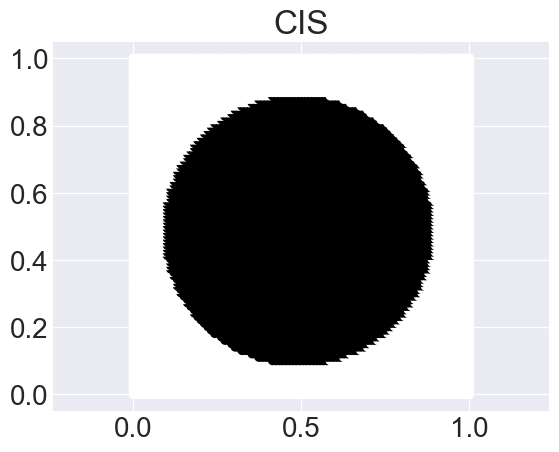

In [4]:
# YOUR CODE HERE
plt.scatter(cis_test_x[:,0], cis_test_x[:,1], c=cis_test_y)
plt.axis('equal')
plt.title("CIS")
plt.show()

## Task 3: Implement Multilayer Perceptron (MLP) with softmax activation and cross-entropy loss

Now that we've tested the softmax activation function and cross-entropy loss functions in a single-layer net, let's implement the MLP version.

Much of your work on the single layer net will carry over, so go ahead and copy-paste and modify as needed!

#### The structure of our MLP

```
Input layer (X units) ->
Hidden layer (Y units) with Rectified Linear activation (ReLu) ->
Output layer (Z units) with softmax activation
```

### 3a. Implement the following functions in `mlp.py`

- `initialize_wts`
- `accuracy`
- `one_hot`
- `predict`
- `forward`
- `backward`
- `fit`: see note below.

#### Updates to `fit`

Now that you have built and fit several neural networks, let's make a helpful update to the training process: in addition to recording the training loss and accuracy, record the accuracy on the **validation set** after every training epoch. Every `print_every` epochs print out validation accuracy to monitor performance on the validation set. See the `fit` docstring for details.

### 3b. Test key functions with randomly generated data

In [5]:
from mlp import MLP

In [6]:
# Create a dummy net for debugging
num_inputs = 3
num_features = 6
num_hidden_units = 7
num_classes = 5

net = MLP(num_features, num_hidden_units, num_classes)

In [7]:
# Generate random data and classes
rng = np.random.default_rng(0)
test_x = rng.normal(loc=0, scale=100, size=(num_inputs, num_features))
test_y = rng.integers(low=0, high=num_classes-1, size=(num_inputs,))
print(f'Test input shape: {test_x.shape}')
print(f'Test class vector shape: {test_y.shape}')

Test input shape: (3, 6)
Test class vector shape: (3,)


#### Test `initialize_wts`

In [8]:
net.initialize_wts(M=num_features, H=num_hidden_units, C=num_classes, std=0.01, r_seed=0)
print(f'y wt shape is {net.y_wts.shape} and should be (6, 7)')
print(f'y bias shape is {net.y_b.shape} and should be (7,)')
print(f'z wt shape is {net.z_wts.shape} and should be (7, 5)')
print(f'z bias shape is {net.z_b.shape} and should be (5,)')

print(f'1st few y wts are\n{net.y_wts[:,0]}\nand should be\n[ 0.001  0.009 -0.012  0.014 -0.005  0.004]')
print(f'y bias is\n{net.y_b}\nand should be\n[ 0.013  0.008  0.003 -0.003  0.015  0.02   0.018]')
print(f'1st few z wts are\n{net.z_wts[:,0]}\nand should be\n[ 0.013 -0.013 -0.007  0.003 -0.022  0.018  0.02 ]')
print(f'z bias is\n{net.z_b}\nand should be\n[-0.013  0.006  0.006  0.013 -0.008]')

y wt shape is (6, 7) and should be (6, 7)
y bias shape is (7,) and should be (7,)
z wt shape is (7, 5) and should be (7, 5)
z bias shape is (5,) and should be (5,)
1st few y wts are
[ 0.001  0.009 -0.012  0.014 -0.005  0.004]
and should be
[ 0.001  0.009 -0.012  0.014 -0.005  0.004]
y bias is
[ 0.013  0.008  0.003 -0.003  0.015  0.02   0.018]
and should be
[ 0.013  0.008  0.003 -0.003  0.015  0.02   0.018]
1st few z wts are
[ 0.013 -0.013 -0.007  0.003 -0.022  0.018  0.02 ]
and should be
[ 0.013 -0.013 -0.007  0.003 -0.022  0.018  0.02 ]
z bias is
[-0.013  0.006  0.006  0.013 -0.008]
and should be
[-0.013  0.006  0.006  0.013 -0.008]


#### Test the `predict` method

In [9]:
test_y_pred = net.predict(test_x)
print(f'Predicted classes are {test_y_pred} and should be [3 0 3]')

Predicted classes are [3 0 3] and should be [3 0 3]


#### Test the `forward` method focusing on`ReLU`(net act of hidden layer `y`)

In [10]:
_,y_net_act_test,_,_,_ = net.forward(test_x, test_y)

correct_y_act = np.array([[0.   , 0.   , 0.433, 0.38 , 0.841, 0.217, 0.464],
       [0.522, 0.362, 0.201, 0.   , 0.   , 0.   , 2.697],
       [0.202, 1.955, 0.   , 0.   , 0.284, 0.   , 0.   ]])

print(f'Your y activation is\n{y_net_act_test}')
print(f'The correct y activation (ReLU) is\n{correct_y_act}')

Your y activation is
[[0.    0.    0.433 0.38  0.841 0.217 0.464]
 [0.522 0.362 0.201 0.    0.    0.    2.697]
 [0.202 1.955 0.    0.    0.284 0.    0.   ]]
The correct y activation (ReLU) is
[[0.    0.    0.433 0.38  0.841 0.217 0.464]
 [0.522 0.362 0.201 0.    0.    0.    2.697]
 [0.202 1.955 0.    0.    0.284 0.    0.   ]]


#### Test the `forward` method

In [11]:
_,_,_,probs,_ = net.forward(test_x, test_y)

correct_probs = np.array([[0.196, 0.2  , 0.201, 0.207, 0.196],
       [0.208, 0.202, 0.196, 0.201, 0.192],
       [0.192, 0.204, 0.203, 0.206, 0.194]])

print(f'Your z activation (class probabilities) is\n{probs}')
print(f'The correct z activation (class probabilities) is\n{correct_probs}')
print(f'The sums for each row (data sample) are {np.sum(probs, axis=1)}.')
print(f'  You should know what should be :)')

Your z activation (class probabilities) is
[[0.196 0.2   0.201 0.207 0.196]
 [0.208 0.202 0.196 0.201 0.192]
 [0.192 0.204 0.203 0.206 0.194]]
The correct z activation (class probabilities) is
[[0.196 0.2   0.201 0.207 0.196]
 [0.208 0.202 0.196 0.201 0.192]
 [0.192 0.204 0.203 0.206 0.194]]
The sums for each row (data sample) are [1. 1. 1.].
  You should know what should be :)


#### Test the `forward` method, focusing on loss

In [12]:
y_in, y_act ,z_in, z_act, loss = net.forward(test_x, test_y)
correct_loss = 1.6067

print(f'Your average loss is\n{loss:.4f}')
print(f'The correct average loss is approx\n{correct_loss}')

Your average loss is
1.6067
The correct average loss is approx
1.6067


#### Test the `forward` method, focusing on regularization

In [13]:
y_in, y_act ,z_in, z_act, loss = net.forward(test_x, test_y, reg=1000)
correct_loss = 4.8772

print(f'Your regularized average loss is\n{loss:.4f}')
print(f'The correct regularized average loss is approx\n{correct_loss}')

Your regularized average loss is
4.8772
The correct regularized average loss is approx
4.8772


#### Test the `backward` method

In [14]:
y_in, y_act ,z_in, z_act, loss = net.forward(test_x, test_y, reg=0.5)
grads = net.backward(test_x, test_y, y_in, y_act ,z_in, z_act, reg=0.5)

print('Your gradient for y_wts is\n', grads[0])
print('Your gradient for y_b is\n', grads[1])
print('Your gradient for z_wts is\n', grads[2])
print('Your gradient for z_b is\n', grads[3])

Your gradient for y_wts is
 [[ 0.064  0.18   0.126  0.017  0.267 -0.068 -0.139]
 [-0.023 -0.148  0.047 -0.021 -0.071  0.061  0.041]
 [ 0.085  0.367  0.043  0.084  0.53  -0.349 -0.392]
 [ 0.095  0.381 -0.081  0.018  0.129 -0.062 -0.014]
 [ 0.051  0.225 -0.138 -0.072 -0.316  0.299  0.387]
 [ 0.016  0.048  0.059  0.052  0.275 -0.206 -0.235]]
Your gradient for y_b is
 [-0.001 -0.004  0.002  0.001  0.006 -0.006 -0.007]
Your gradient for z_wts is
 [[ 0.056 -0.191  0.042  0.049  0.05 ]
 [ 0.144 -0.613  0.158  0.162  0.144]
 [-0.105 -0.027  0.036  0.052  0.039]
 [-0.1    0.024  0.033  0.033  0.028]
 [-0.218 -0.019  0.079  0.082  0.07 ]
 [-0.049  0.008  0.011  0.02   0.014]
 [ 0.073 -0.685  0.204  0.211  0.198]]
Your gradient for z_b is
 [-0.135 -0.465  0.2    0.205  0.194]


The correct gradients are:

```
Your gradient for y_wts is
 [[ 0.064  0.18   0.126  0.017  0.267 -0.068 -0.139]
 [-0.023 -0.148  0.047 -0.021 -0.071  0.061  0.041]
 [ 0.085  0.367  0.043  0.084  0.53  -0.349 -0.392]
 [ 0.095  0.381 -0.081  0.018  0.129 -0.062 -0.014]
 [ 0.051  0.225 -0.138 -0.072 -0.316  0.299  0.387]
 [ 0.016  0.048  0.059  0.052  0.275 -0.206 -0.235]]
Your gradient for y_b is
 [-0.001 -0.004  0.002  0.001  0.006 -0.006 -0.007]
Your gradient for z_wts is
 [[ 0.056 -0.191  0.042  0.049  0.05 ]
 [ 0.144 -0.613  0.158  0.162  0.144]
 [-0.105 -0.027  0.036  0.052  0.039]
 [-0.1    0.024  0.033  0.033  0.028]
 [-0.218 -0.019  0.079  0.082  0.07 ]
 [-0.049  0.008  0.011  0.02   0.014]
 [ 0.073 -0.685  0.204  0.211  0.198]]
Your gradient for z_b is
 [-0.135 -0.465  0.2    0.205  0.194]
```

#### Test loss over epoch (1 of 2). 

The below code should generate a curve that rapidly drops to 0 (there might be fluctuations and it might not be monotonic and that's ok)

Your `fit` function should show you print-outs showing:
- Loss and validation accuracy 4 times throughout training.
- 100% accuracy on validation set after around 5 epochs of training.
- You are training on 20 epochs.
- There are 20 iterations.
- There is 1 iteration per epoch.

Here is an example print-out from `fit`:

    Starting to train network...There will be 20 epochs and 20 iterations total, 1 iter/epoch.
    Completed Epoch 0/19. Training loss: 3.53. Training acc:   0.00%. Validation acc:   0.00%.
    Completed Epoch 5/19. Training loss: 0.62. Training acc:  66.67%. Validation acc:  66.67%.
    Completed Epoch 10/19. Training loss: 0.44. Training acc: 100.00%. Validation acc: 100.00%.
    Completed Epoch 15/19. Training loss: 0.17. Training acc: 100.00%. Validation acc: 100.00%.
    Finished training!

Epoch 1/20, Loss: 3.1184, Training Accuracy: 0.0000, Validation Accuracy: 0.0000
Epoch 6/20, Loss: 0.8035, Training Accuracy: 0.6667, Validation Accuracy: 0.6667
Epoch 11/20, Loss: 0.3300, Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 16/20, Loss: 0.1787, Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 20/20, Loss: 0.1251, Training Accuracy: 1.0000, Validation Accuracy: 1.0000

Lengths of each output list:
len(loss_hist)=20, len(acc_train)=20, len(acc_valid)=20
Each should be 20.


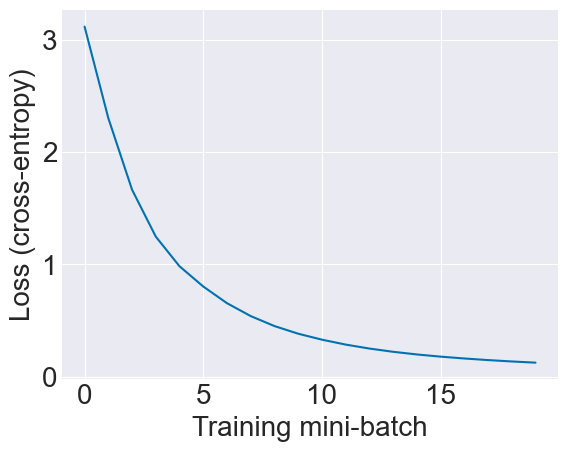

In [20]:
net = MLP(num_features, num_hidden_units, num_classes)
loss_hist, acc_train, acc_valid = net.fit(test_x, test_y, test_x, test_y,
                                          reg=0,
                                          print_every=5,
                                          lr=0.001,
                                          mini_batch_sz=3,
                                          n_epochs=20,
                                          r_seed=0)

print('\nLengths of each output list:')
print(f'{len(loss_hist)=}, {len(acc_train)=}, {len(acc_valid)=}')
print('Each should be 20.')

plot_cross_entropy_loss(loss_hist)

#### Test loss over epoch (2 of 2). 

The below curve should look similar, perhaps a little bumpier.

Your `fit` function should print out:
- Loss and validation accuracy 5 times throughout training.
- 100% accuracy on validation set after around 2 epochs of training.
- You are training on 10 epochs.
- There are 30 iterations.
- There are 3 iterations per epoch.


Epoch 1/10, Loss: 3.5577, Training Accuracy: 0.6667, Validation Accuracy: 0.6667
Epoch 3/10, Loss: 0.3758, Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 5/10, Loss: 0.3059, Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 7/10, Loss: 0.1094, Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 9/10, Loss: 0.1090, Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 10/10, Loss: 0.0572, Training Accuracy: 1.0000, Validation Accuracy: 1.0000

Lengths of each output list:
len(loss_hist)=30, len(acc_train)=10, len(acc_valid)=10
The lengths should be 30, 10, 10.


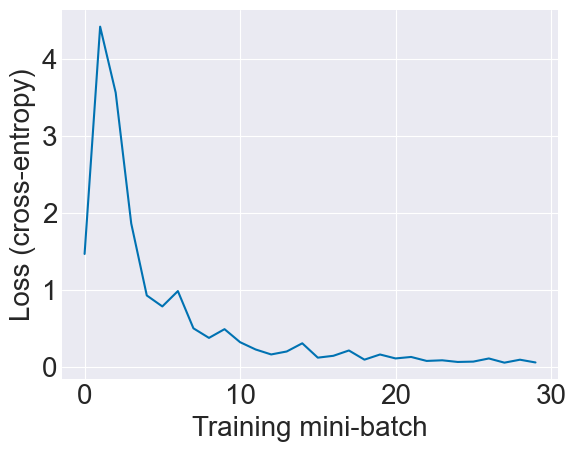

In [21]:
net = MLP(num_features, num_hidden_units, num_classes)
loss_hist, acc_train, acc_valid = net.fit(test_x, test_y, test_x, test_y,
                                          reg=0,
                                          print_every=2,
                                          lr=0.001,
                                          mini_batch_sz=1,
                                          n_epochs=10,
                                          r_seed=2)

print('\nLengths of each output list:')
print(f'{len(loss_hist)=}, {len(acc_train)=}, {len(acc_valid)=}')
print('The lengths should be 30, 10, 10.')

plot_cross_entropy_loss(loss_hist)

### 3c. Test MLP with Circle in Square dataset

Before you run your MLP on the STL-10 dataset, test it out on the simpler CIS dataset.

In cells below:
- Train an MLP using the CIS training and validation sets. Configure the MLP with the following non-default hyperparameters:
    - 50 hidden units
    - Learning rate of `0.5`
    - Mini-batch size of `80`
    - `600` epochs
    - Random seed of `0`
- Plot the loss over training iterations. You should see:
    - A nice drop and plateau in mini-batch training loss (*with a few potentially large fluctuations along the way*).
    - Accuracy on the validation set reach ~85-90%.
- Create a scatter plot of the MLP predictions on the CIS test set. Color-code each sample by its class. Make sure your axis aspect ratios are equal.

Epoch 1/600, Loss: 0.6946, Training Accuracy: 0.4625, Validation Accuracy: 0.5000
Epoch 11/600, Loss: 0.6897, Training Accuracy: 0.5500, Validation Accuracy: 0.5500
Epoch 21/600, Loss: 0.6867, Training Accuracy: 0.5375, Validation Accuracy: 0.4500
Epoch 31/600, Loss: 0.6838, Training Accuracy: 0.6000, Validation Accuracy: 0.4500
Epoch 41/600, Loss: 0.6806, Training Accuracy: 0.6000, Validation Accuracy: 0.4500
Epoch 51/600, Loss: 0.6771, Training Accuracy: 0.6250, Validation Accuracy: 0.4500
Epoch 61/600, Loss: 0.6732, Training Accuracy: 0.6250, Validation Accuracy: 0.4500
Epoch 71/600, Loss: 0.6688, Training Accuracy: 0.6250, Validation Accuracy: 0.4500
Epoch 81/600, Loss: 0.6636, Training Accuracy: 0.6250, Validation Accuracy: 0.4500
Epoch 91/600, Loss: 0.6576, Training Accuracy: 0.6375, Validation Accuracy: 0.4500
Epoch 101/600, Loss: 0.6506, Training Accuracy: 0.6375, Validation Accuracy: 0.5000
Epoch 111/600, Loss: 0.6424, Training Accuracy: 0.6625, Validation Accuracy: 0.5000
Epo

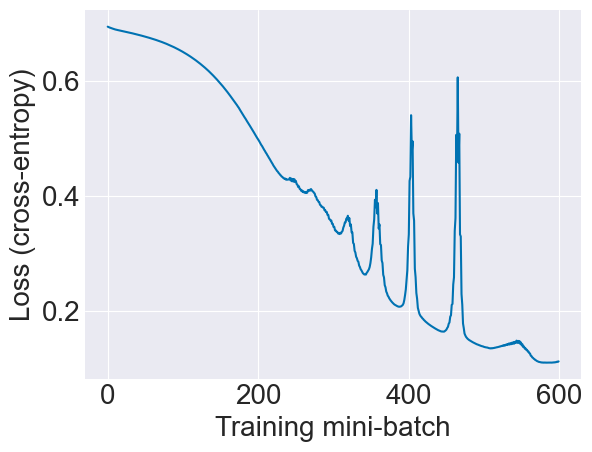

In [26]:
# YOUR CODE HERE
net = MLP(cis_train_x.shape[1], 50, 2)
loss_hist, acc_train, acc_valid = net.fit(cis_train_x, cis_train_y, cis_val_x, cis_val_y,
                                          reg=0,
                                          print_every=10,
                                          lr=0.5,
                                          mini_batch_sz=80,
                                          n_epochs=600,
                                          r_seed=0)

plot_cross_entropy_loss(loss_hist)



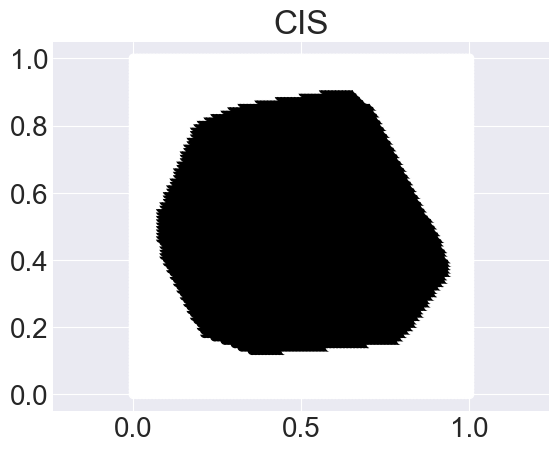

Accuracy on CIS test set is 94.58%


In [27]:
# YOUR CODE HERE

y_pred = net.predict(cis_test_x)
plt.scatter(cis_test_x[:,0], cis_test_x[:,1], c=y_pred)
plt.axis('equal')
plt.title("CIS")
plt.show()

print(f'Accuracy on CIS test set is {np.mean(y_pred == cis_test_y)*100:.2f}%')

**Question 6**: How do you interpret the circle-in-square scatterplot? Is the MLP doing a good job? 

**Answer 6**: 

Generally, yes. While it does not produce a perfect circle in square, the resulting area is still quite round and roughly accurate in size to the original dataset, and it is handling the circular decision boundary fairly well. Thereby, the network is generalizing to the test data quite well. The network appears to pick up on more rounded features on the left than the right, resulting in a sharp line in the top right and a bulge in the bottom right rather than a rounded edge, which is where I suspect the majority of misclassifications are. 

**Question 7**: Play with
- number of hidden units
- number of epochs
- batch size

How does each parameter affect the results?

Epoch 1/200, Loss: 4.4637, Training Accuracy: 0.5000, Validation Accuracy: 0.5000
Epoch 11/200, Loss: 63.8390, Training Accuracy: 0.6250, Validation Accuracy: 0.6000
Epoch 21/200, Loss: 5.6752, Training Accuracy: 0.8875, Validation Accuracy: 0.9500
Epoch 31/200, Loss: 0.0022, Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 41/200, Loss: 0.0018, Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 51/200, Loss: 0.0015, Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 61/200, Loss: 0.0014, Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 71/200, Loss: 0.0013, Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 81/200, Loss: 0.0012, Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 91/200, Loss: 0.0012, Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 101/200, Loss: 0.0011, Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 111/200, Loss: 0.0011, Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Ep

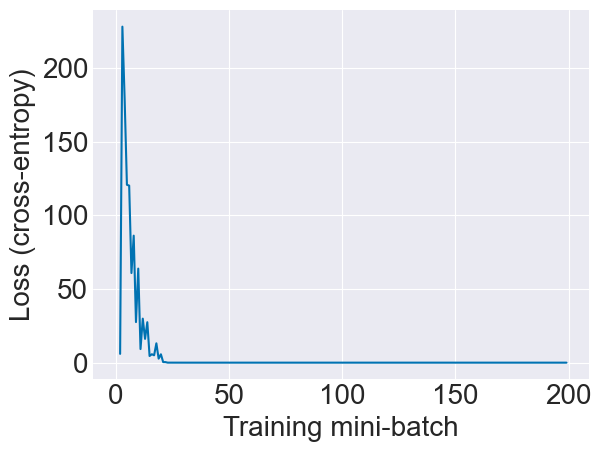

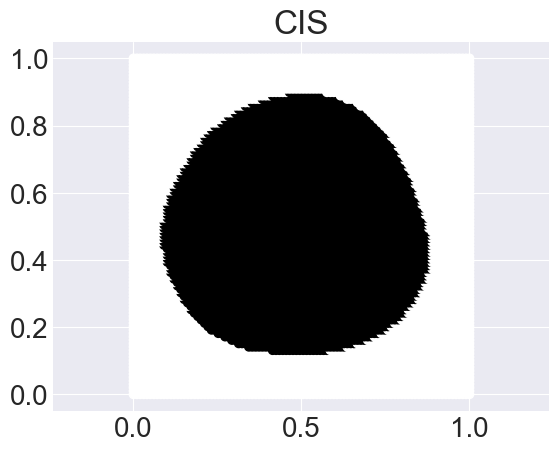

In [50]:

net = MLP(cis_train_x.shape[1], 200000, 5)
loss_hist, acc_train, acc_valid = net.fit(cis_train_x, cis_train_y, cis_val_x, cis_val_y,
                                          reg=0,
                                          print_every=10,
                                          lr=0.5,
                                          mini_batch_sz=300,
                                          n_epochs=200,
                                          r_seed=0)

plot_cross_entropy_loss(loss_hist)

plt.scatter(cis_test_x[:,0], cis_test_x[:,1], c=net.predict(cis_test_x))

plt.axis('equal')

plt.title("CIS")

plt.show()



**Answer 7**:

Increasing the hidden units by several orders of magnitude appears to contribute most towards a more accurate circular boundary with far less loss, but is more resource intensive. Lowering this produced notably worse results than the original model, but is slightly faster. Increasing the batch size alongside it helps smooths the loss curve out, but is more computationally intensive. Decreasing the batch size helps speed training up, but the resulting erratic loss curve makes it more difficult to reach the global minimum. Increasing the number of epochs only really helps if the loss continues to decline by the end of training, or the accuracy has not yet reached its highest. In scenarios where the loss plateaus for many epochs, limiting the number of epochs further is advisable to prevent overfitting.

Our best result was 0.0009 loss, 100% train/val accuracy w/ 200000 units, 300 batch size, 200 epochs and the plot above (much more circular, captures all rounded corners, top/bottom/side edges very similar to original dataset). A very similar result can be achieved with fewer epochs and a lower number of units, but the result would have very marginally higher loss and perhaps slightly lower accuracy. Here, we chose to leave it as is since these parameters generalize very well to the data, with a 0.97 accuracy on the test set, and thereby the model does not appear to be overfitting.

**Question 8**: Do you think the single-layer net (with softmax) can handle the CIS dataset? Why or why not? (You're invited to try it, maybe as an extension :)

**Answer 8**: 

No, not by default. The CIS dataset has a nonlinear decision boundary, which a single-layer net cannot handle as it can only form linear decision boundaries, essentially splitting the circle down the middle but not being able to accurately separate them out. The features could be manipulated beforehand to better fit this, but then it wouldn't really be a circle in a square.

### 3d. Test on STL-10 dataset, plot performance

Train an MLP on the STL-10 training set with the following non-default hyperparameters:
- 50 hidden units
- Learning rate of 0.1
- Regularization strength of 0.001
- Mini-batch size of 500
- 100 epochs
    
Make two plots:
- Plot the training loss (like usual). *Remember: the units are mini-batches.*
- Plot the training and validation set accuracies (2 curves in one plot — include a legend, title, axis labels, etc.). *Remember: the units are epochs.*

In [53]:
# # YOUR CODE HERE
# Train an MLP on the STL-10 training set with the following non-default hyperparameters:
# - 50 hidden units
# - Learning rate of 0.1
# - Regularization strength of 0.001
# - Mini-batch size of 500
# - 100 epochs

net = MLP(x_train.shape[1], 50, 10)
loss_hist, acc_train, acc_valid = net.fit(x_train, y_train, x_val, y_val,
                                          reg=0.001,
                                          print_every=10,
                                          lr=0.1,
                                          mini_batch_sz=500,
                                          n_epochs=100,
                                          r_seed=0)




Epoch 1/100, Loss: 3.5085, Training Accuracy: 0.2283, Validation Accuracy: 0.2120
Epoch 11/100, Loss: 2.4512, Training Accuracy: 0.4163, Validation Accuracy: 0.3100
Epoch 21/100, Loss: 2.2095, Training Accuracy: 0.4703, Validation Accuracy: 0.3370
Epoch 31/100, Loss: 2.0064, Training Accuracy: 0.5537, Validation Accuracy: 0.3490
Epoch 41/100, Loss: 1.7817, Training Accuracy: 0.6370, Validation Accuracy: 0.3390
Epoch 51/100, Loss: 1.6542, Training Accuracy: 0.7147, Validation Accuracy: 0.3270
Epoch 61/100, Loss: 1.4198, Training Accuracy: 0.7883, Validation Accuracy: 0.3450
Epoch 71/100, Loss: 1.2556, Training Accuracy: 0.8703, Validation Accuracy: 0.3390
Epoch 81/100, Loss: 1.1150, Training Accuracy: 0.9213, Validation Accuracy: 0.3460
Epoch 91/100, Loss: 1.0228, Training Accuracy: 0.9517, Validation Accuracy: 0.3420
Epoch 100/100, Loss: 0.9441, Training Accuracy: 0.9493, Validation Accuracy: 0.3300


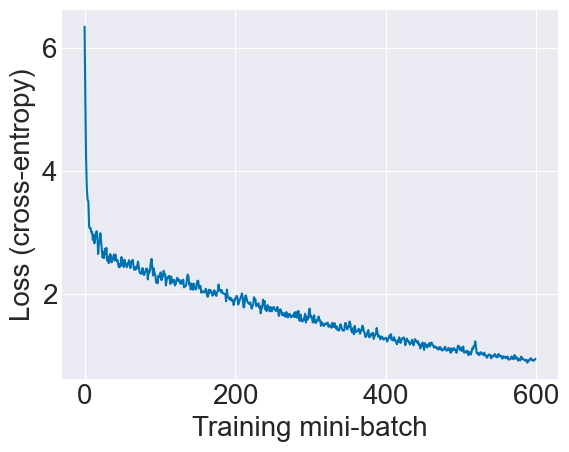

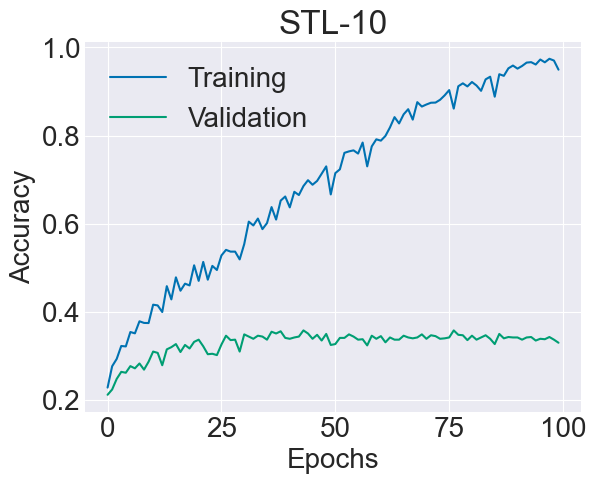

In [54]:
# YOUR CODE HERE

plot_cross_entropy_loss(loss_hist)

#Plot the training and validation set accuracies (2 curves in one plot — include a legend, title, axis labels, etc.). *Remember: the units are epochs.*

plt.plot(acc_train, label='Training')
plt.plot(acc_valid, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('STL-10')
plt.show()


### 3e. Questions

**Question 9**: What do the above loss and training and validation accuracy curves suggest about the quality of the hyperparameters used during training?

**Answer 9:**

Judging by the loss curve, the net is has not yet plateau'd and reached a global minimum. Adjusting the learning rate or number of epochs here may help. Additionally, there is some erratic movement on the loss curve, so regularizing or increasing batch size may help to smooth this out.

The training vs validation accuracy curve shows that the training accuracy continues to improve, but does not quite plateau, while the validation accuracy climbs to about 0.33 and stays there. This, and the large gap between the training set and val set could indicate that the model is not capturing more complex relationships in its decision boundaries, resulting in poor generalization to unseen data. Increasing the number of hidden units may help.

Overall, the chosen parameters used for this training are not suitable for the model, as it does not do a good job generalizing to the data, and there is evidently more room for improvement in the chosen parameters based on the plots.

### 3f. Optimize on STL-10 dataset with random search

To optimize your MLP hyperparameters on STL-10, try a **random search** rather than a grid search. This means that instead of defining preset *values* that each hyperparameter takes on, define *ranges* (min and max values).

Run your search for some $T$ iterations. On each iteration, randomly assign values to each hyperparameter within their valid ranges.

Just like grid search:
- print out the accuracy and parameter values every time a bout of training yields the **best accuracy** on the **STL-10 validation set**. That way, if you need to stop the search prematurely, you know the current best hyperparameter combination.
- make sure your results from the search are reproducible and you can train a net after the search is over and get the same accuracy.

Consider combinations of the following hyperparameters:
- learning rate
- regularization strength
- number of hidden units
- mini-batch size
- number of epochs (try between `1` and `150`). *Reduce the upper limit if your machine is taking too long to train a net with this many epochs.*

**Important note:** Like usual, I am not grading based on how long you search. I want to see that you successfully implemented the random search to find progressively better hyperparameters on STL-10. You should be able to improve upon your softmax net accuracy from last week.

**Tips:**
- Just like with grid search, if you find a cluster of parameters that seems promising, you can revise your search to hone in on that smaller range.
- Turn off print outs from `fit` (adjust `verbose` argument) and only print out things related to your search.
- If you are getting `RuntimeWarning`, your learning rate may be too high.

In [64]:
# Set the number of random search iterations
T = 30

# Set the ranges for each hyperparameter

# Learning rate
lr_min = 1e-5
lr_max = 1e-1

# Regularization strength
reg_min = 1e-5
reg_max = 1e-1

# Number of hidden units
H_min = 10
H_max = 500

# Mini-batch size
mini_batch_min = 4
mini_batch_max = 256

# Number of epochs
n_epochs_min = 1
n_epochs_max = 150

# Initialize the best accuracy to 0
best_acc = 0

# Initialize the best hyperparameters to None
best_hyperparams = None

# Initialize the loss history to None
best_loss_hist = None

# Initialize the training accuracy to None
best_acc_train = None

# Initialize the validation accuracy to None
best_acc_valid = None

# Initialize the random seed to 0
r_seed = 0

# Loop over the number of random search iterations
for t in range(T):
    # Randomly sample hyperparameters from the ranges
    lr = np.random.uniform(lr_min, lr_max)
    reg = np.random.uniform(reg_min, reg_max)
    H = np.random.randint(H_min, H_max)
    mini_batch_sz = np.random.randint(mini_batch_min, mini_batch_max)
    n_epochs = np.random.randint(n_epochs_min, n_epochs_max)
    print(f'Iteration {t+1}/{T}: lr={lr:.4f}, reg={reg:.4f}, H={H}, mini_batch_sz={mini_batch_sz}, n_epochs={n_epochs}')
    
    # Train an MLP with the hyperparameters
    net = MLP(x_train.shape[1], H, 10)
    loss_hist, acc_train, acc_valid = net.fit(x_train, y_train, x_val, y_val,
                                              reg=reg,
                                              print_every=n_epochs+1,
                                              lr=lr,
                                              mini_batch_sz=mini_batch_sz,
                                              n_epochs=n_epochs,
                                              r_seed=r_seed)
    
    # Get the final validation accuracy
    final_acc = acc_valid[-1]
    

    # If the final validation accuracy is the best so far, update the best accuracy, best hyperparameters, and best loss history
    if final_acc > best_acc:
        print(f'New best validation accuracy: {final_acc:.4f}')
        best_acc = final_acc
        best_hyperparams = (lr, reg, H, mini_batch_sz, n_epochs)
        best_loss_hist = loss_hist
        best_acc_train = acc_train
        best_acc_valid = acc_valid

# Print out the best hyperparameters and the best accuracy
print(f'Best hyperparameters: {best_hyperparams}')
print(f'Best accuracy: {best_acc:.4f}')

Iteration 1/30: lr=0.0356, reg=0.0284, H=487, mini_batch_sz=34, n_epochs=99
Epoch 1/99, Loss: 182.9054, Training Accuracy: 0.2270, Validation Accuracy: 0.1930
Epoch 99/99, Loss: 0.9349, Training Accuracy: 0.9273, Validation Accuracy: 0.4040
Final validation accuracy: 0.4040
Iteration 2/30: lr=0.0414, reg=0.0879, H=336, mini_batch_sz=134, n_epochs=80
Epoch 1/80, Loss: 393.6237, Training Accuracy: 0.2653, Validation Accuracy: 0.2400
Epoch 80/80, Loss: 1.7578, Training Accuracy: 0.7663, Validation Accuracy: 0.4100
Final validation accuracy: 0.4100
Iteration 3/30: lr=0.0582, reg=0.0828, H=260, mini_batch_sz=50, n_epochs=71
Epoch 1/71, Loss: 190.1175, Training Accuracy: 0.3673, Validation Accuracy: 0.2650
Epoch 71/71, Loss: 1.9621, Training Accuracy: 0.6457, Validation Accuracy: 0.3960
Final validation accuracy: 0.3960
Iteration 4/30: lr=0.0178, reg=0.0014, H=135, mini_batch_sz=240, n_epochs=81
Epoch 1/81, Loss: 6.7439, Training Accuracy: 0.2330, Validation Accuracy: 0.1860
Epoch 81/81, Los

### 3g. Plot STL-10 results with best hyperparameters

Train an MLP with the best hyperparameters that you found from your parameter search and create two plots:
- Training STL-10 loss curve
- Training and validation set STL-10 accuracy curves. **Place the test set accuracy in the plot title.**

Epoch 1/89, Loss: 60.8235, Training Accuracy: 0.2640, Validation Accuracy: 0.2190
Epoch 2/89, Loss: 48.9357, Training Accuracy: 0.2730, Validation Accuracy: 0.2040
Epoch 3/89, Loss: 40.6034, Training Accuracy: 0.4313, Validation Accuracy: 0.2110
Epoch 4/89, Loss: 34.4599, Training Accuracy: 0.5273, Validation Accuracy: 0.2850
Epoch 5/89, Loss: 30.9845, Training Accuracy: 0.4897, Validation Accuracy: 0.2590
Epoch 6/89, Loss: 26.2921, Training Accuracy: 0.5437, Validation Accuracy: 0.2650
Epoch 7/89, Loss: 22.2176, Training Accuracy: 0.7740, Validation Accuracy: 0.3360
Epoch 8/89, Loss: 19.4397, Training Accuracy: 0.7237, Validation Accuracy: 0.2910
Epoch 9/89, Loss: 17.7182, Training Accuracy: 0.5877, Validation Accuracy: 0.2730
Epoch 10/89, Loss: 14.7140, Training Accuracy: 0.8570, Validation Accuracy: 0.3350
Epoch 11/89, Loss: 12.9484, Training Accuracy: 0.7737, Validation Accuracy: 0.3290
Epoch 12/89, Loss: 11.1097, Training Accuracy: 0.7860, Validation Accuracy: 0.3060
Epoch 13/89, 

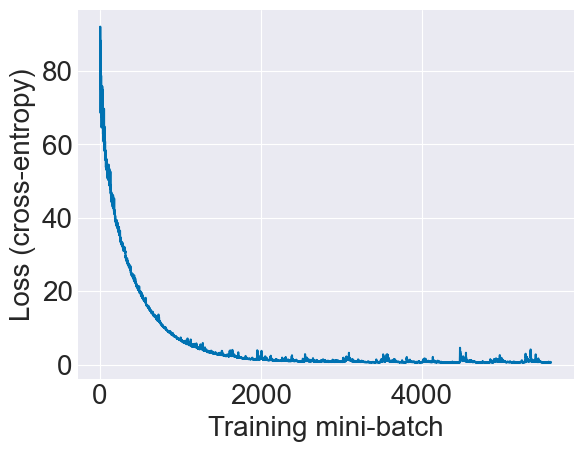

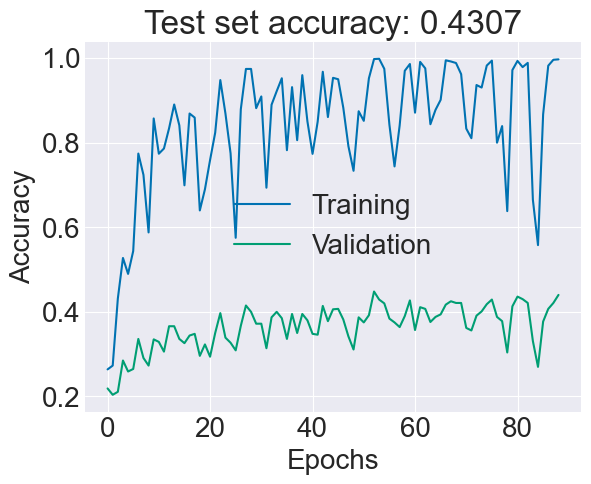

In [82]:
# YOUR CODE HERE

bestNet = MLP(x_train.shape[1], 311, 10)
loss_hist, acc_train, acc_valid = bestNet.fit(x_train, y_train, x_val, y_val, reg=0.012316367377938, print_every=1, lr=0.09319913153827034, mini_batch_sz=48, n_epochs=89, r_seed=0)

#find accuracy on test set
y_pred = bestNet.predict(x_test)
acc_test = bestNet.accuracy(y_test, y_pred)

plot_cross_entropy_loss(loss_hist)

plt.plot(acc_train, label='Training')
plt.plot(acc_valid, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title(f"Test set accuracy: {acc_test:.4f}")
plt.show()


### 3i. Visualize learned weights

Run the `plot_weights` function to generate a grid visualization of them.

You should see structure in the weights if your network is performing well. If you have a large number of hidden units, some may not be "used" so a subset of the weights may resemble "noise".

In [83]:
best_y_wts = bestNet.get_y_wts()
best_y_wts = best_y_wts.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)

In [85]:
def plot_weights(wts, maxRows=25, verbose=0):
    # limit height of figure by number of neurons
    grid_sz = int(maxRows)
    grid_sz = np.minimum(grid_sz, int(np.sqrt(len(wts))))

    if verbose > 0:
        print(f'Showing {grid_sz} rows')

    plt.figure(figsize=(20,20))
    for x in range(grid_sz):
        for y in range(grid_sz):
            lin_ind = np.ravel_multi_index((x, y), dims=(grid_sz, grid_sz))
            plt.subplot(grid_sz, grid_sz, lin_ind+1)
            currImg = wts[lin_ind]
            low, high = np.min(currImg), np.max(currImg)
            currImg = 255*(currImg - low) / (high - low)
            currImg = currImg.astype('uint8')
            plt.imshow(currImg)
            plt.gca().axis('off')
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    plt.show()

Showing 17 rows


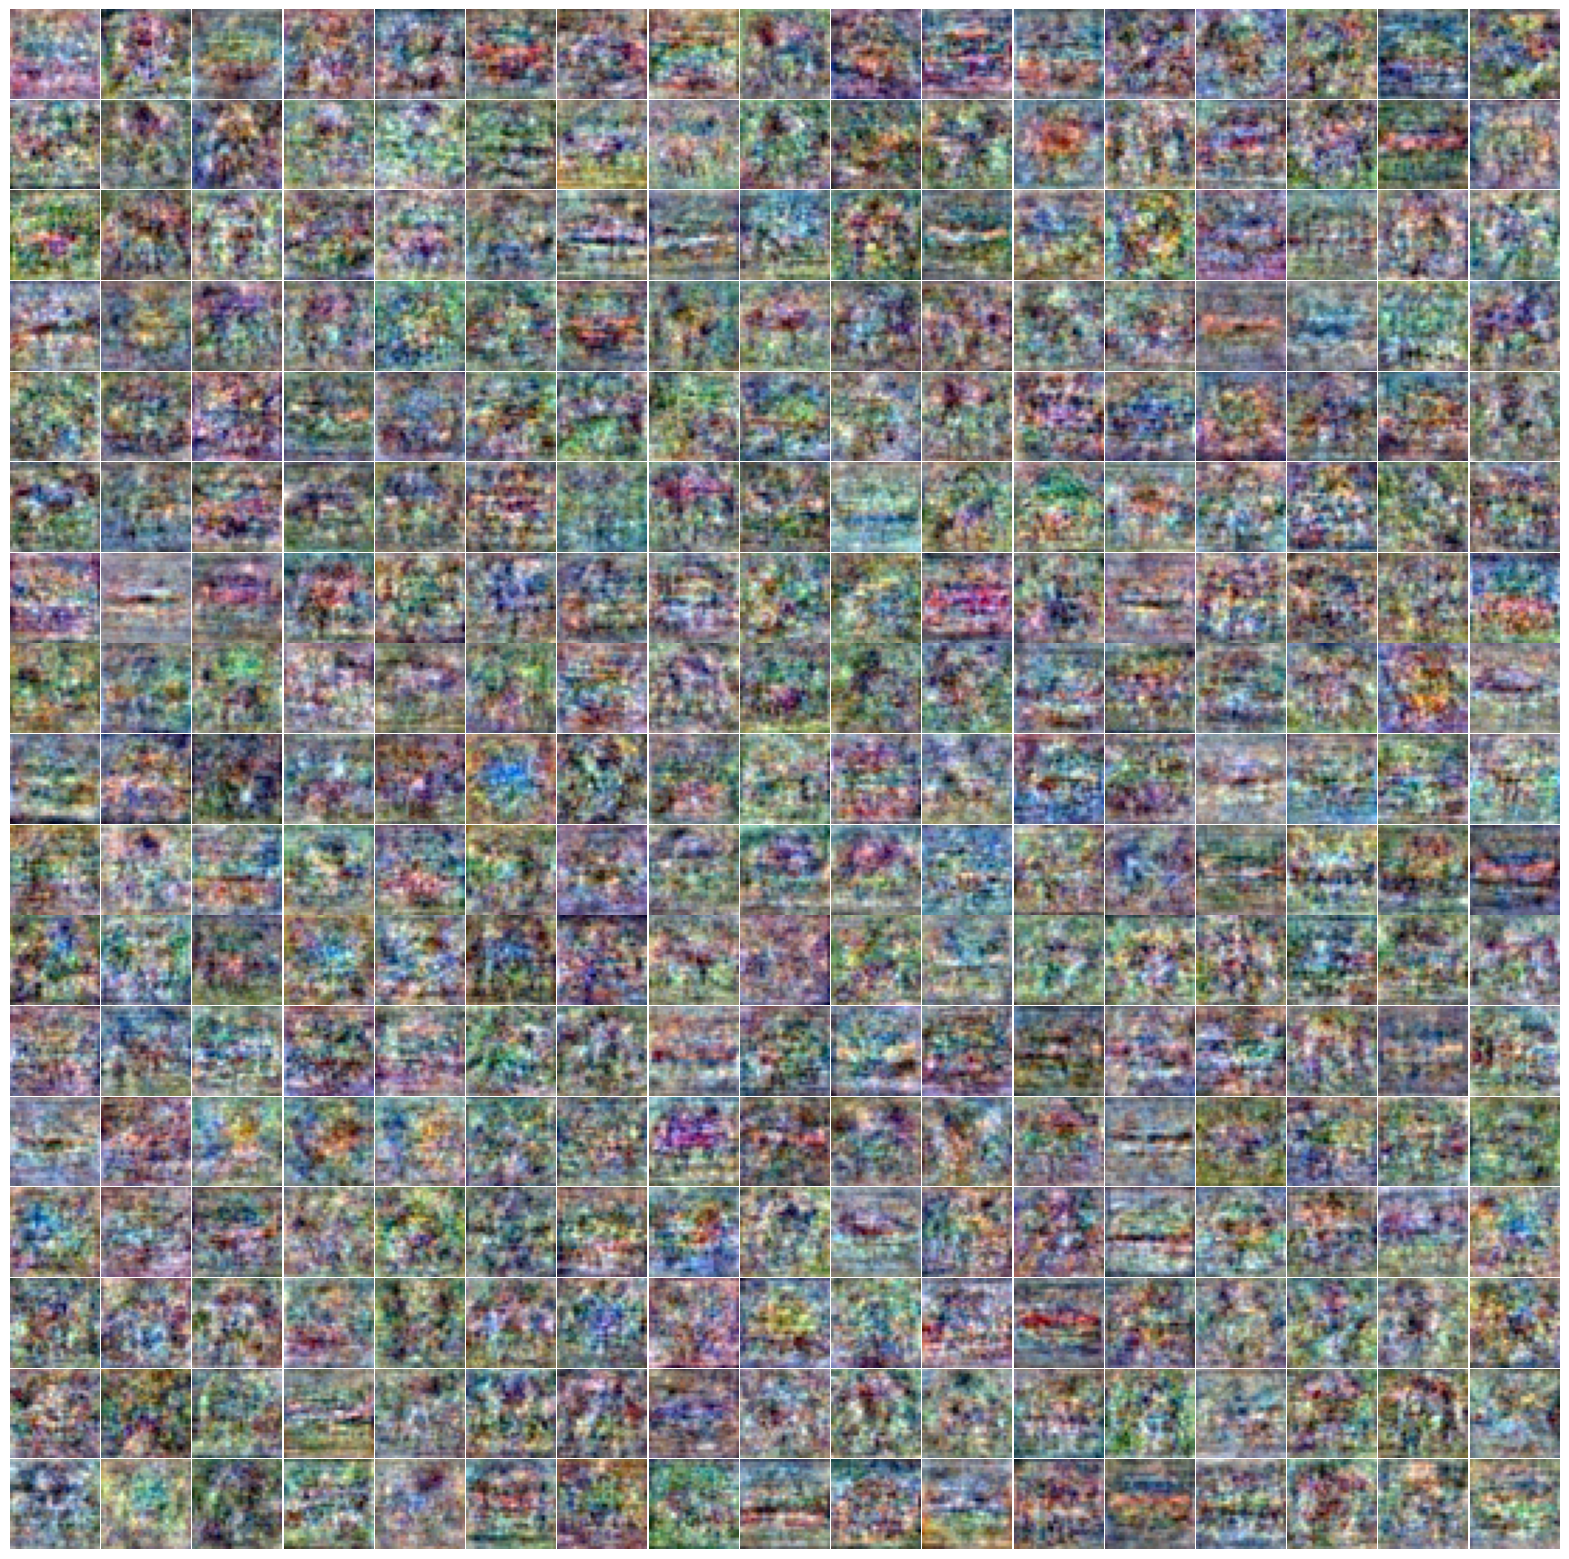

In [86]:
plot_weights(best_y_wts, verbose=1)

## Extensions

### General guidelines

1. Never integrate extensions into your base project so that they change the expected behavior of core functions. If your extension changes the core design/behavior, no problem, duplicate your working base project and add features from there.
2. Check the rubric to keep in mind how extensions on this project will be graded.
3. While I may consult your code and "written log" of what you did, **I am grading your extensions based on what you present in your 3-5 min video.**
3. I suggest documenting your explorations in a "log" or "lab notebook" style (i.e. documenting your thought/progression/discovery/learning process). I'm not grading your writing, so you can keep it succinct. **Whatever is most useful to you to remember what you did.** 
4. I suggest taking a hypothesis driven approach. For example "I was curious about X so I explored Y. I found Z, which was not what I expected because..., so then tried A..."
5. Make plots to help showcase your results.
6. **More is not necessarily better.** Generally, a small number of "in-depth" extensions count for more than many "shallow" extensions.

### AI guidelines

You may use AI in mostly any capacity for extensions. However, keep in mind:
1. There is no need to use AI at all!
2. You are welcome to use AI as a tool (e.g. automate something that is tedious, help you get unstuck, etc.). However, you should be coding, you should be thinking, you should be writing, you should be creating. If you are spending most (or even close to most) of your time typing into a chatbot and copy-pasting, you have probably gone too far with AI use.
3. I don't find large volumes of AI generated code/text/plots to be particularly impressive and you risk losing my interest while grading. Remember: I'm grading your extensions based on your video presentation. **More is not necessarily better.**

### Video guidelines

1. Please try to keep your video to 5 minutes (*I have other projects to grade!*). If you turn in a longer video, I make no promise that I will watch more than 5 minutes.
2. Your screen should be shared as you show me what you did. A live video of your face should also appear somewhere on the screen (e.g. picture-in-picture overlay / split screen).
3. Your partner should join you for the video and take turns talking, but, if necessary, it is fine to have one team member present during the record the video.
4. Do not simply read text from your notebook, do not read from a prepared script. I am not grading how polished your video presentation is (see extension grading criteria on rubric). 
5. I am looking for original and creative explorations sparked by your curiosity/interest/passion in a topic. This should be apparent in your video.
6. Be natural,, don't feel the need to impress me with fancy language. If it is helpful, imagine that we are talking one-on-one about your extension. Tell me what you did :)

### Extension ideas

1) There are many other activation functions that could be used for the hidden layer (e.g. Sigmoid, Leaky ReLU, SELU, GELU, Softplus, Mish, etc.). Research one or more, implement them, and compare results with ReLU.

2) Run hyperparameter searches with the nets configured with the different hidden activation functions and explore the extent to which performance improves compare to ReLU.

3) Analyze the differences between training when sampling with replacement (i.e. not every input sample is usually processed on an epoch) and sampling without replacement (e.g. time, accuracy, loss, etc).

4) Investigate how the single layer softmax network does with the CIS dataset. Explain and provide plots showing your results.

5) If you have time to spare (or want to throw more computing power at the STL-10 dataset), process through the Softmax network or MLP and tune hyperparameters with the dataset at its original resolution (96x96 images). Show images of your learned weights. Can you find a training sweet spot where the learned weight visualizations look particularly cool?

6) Implement a multi-class sigmoid classifier (sigmoid activation function in the output layer). I suggest creating another subclass of `SoftmaxLayer` and/or `MLP`. This extension requires some thought. Compare and contrast results achieved by the softmax network.

7) Explore alternative MLP architectures and compare/contrast results and performance with the ones used in the base project. For example, add one or more additional hidden layers.

8)  Explore the effects of batch gradient descent, stochastic gradient descent, and mini-batch gradient descent. Make plots and interpret your results.

9)  Obtain, preprocess, train, and evaluate the performance of `SoftmaxLayer` and/or `MLP` on another dataset with comparable types of image features. MNIST and Fashion MNIST are good ones.

10) Make a fancy coarse-to-fine grid search that automatically "zooms in" on the best hyperparameter combination ranges several times.

11) Because each grid search training session is independent of the others, they can be parallelized. Research parallel computing / multithreading in Python to implement a parallel version of grid search or random search. Characterize the speed gains offered by the parallel search implementation.

## HyperZoom Grid Search

In [38]:
import itertools

#perform grid search using all combinations of parameters
def grid_search(lr, reg, H, mini_batch_sz, n_epochs, x_train, y_train, x_val, y_val, top=3, classes = 2):
    results = []
    
    for i in itertools.product(lr, reg, H, mini_batch_sz, n_epochs):
        #print(f'lr={i[0]}, reg={i[1]}, H={i[2]}, mini_batch_sz={i[3]}, n_epochs={i[4]}')
        net = MLP(x_train.shape[1], i[2], classes)
        loss_hist, acc_train, acc_valid = net.fit(x_train, y_train, x_val, y_val,
                                                  reg=i[1],
                                                  verbose=0,
                                                  lr=i[0],
                                                  mini_batch_sz=i[3],
                                                  n_epochs=i[4],
                                                  r_seed=0)
        
        results.append((acc_valid[-1], i))
    
    # Sort results by accuracy in descending order and get the top x
    results.sort(key=lambda x: x[0], reverse=True)
    best_models = results[:top]

    return best_models

def hyper_zoom(best_models):
    #take the hyperparameters from the best models, and add themselves, their half and double values to a new parameter list
    lr = []
    reg = []
    H = []
    mini_batch_sz = []
    n_epochs = []


    for model in best_models:
        lr.append(model[1][0])
        lr.append(model[1][0]/2)
        lr.append(model[1][0]*2)


        reg.append(model[1][1])
        reg.append(model[1][1]/2)
        reg.append(model[1][1]*2)

        H.append(model[1][2])
        H.append(model[1][2]/2)
        H.append(model[1][2]*2)

        mini_batch_sz.append(model[1][3])
        mini_batch_sz.append(model[1][3]/2)
        mini_batch_sz.append(model[1][3]*2)
        
        n_epochs.append(model[1][4])
        n_epochs.append(model[1][4]/2)
        n_epochs.append(model[1][4]*2)



    #clean up duplicates from lists
    lr = list(set(lr))
    reg = list(set(reg))
    H = list(set(H))
    mini_batch_sz = list(set(mini_batch_sz))
    n_epochs = list(set(n_epochs))

    #round everything to the nearest integer
    H = [int(round(i)) for i in H]
    mini_batch_sz = [int(round(i)) for i in mini_batch_sz]
    n_epochs = [int(round(i)) for i in n_epochs]

    return lr, reg, H, mini_batch_sz, n_epochs



def zooming_grid_search(lr, reg, H, mini_batch_sz, n_epochs, x_train, y_train, x_val, y_val, top=3, classes = 2):
    previous_best_models = None
    while True:
        print('Current hyperparameter grid')
        print(f'lr: {lr}')
        print(f'reg: {reg}')
        print(f'H: {H}')
        print(f'mini_batch_sz: {mini_batch_sz}')
        print(f'n_epochs: {n_epochs}')

        best_models = grid_search(lr, reg, H, mini_batch_sz, n_epochs, x_train, y_train, x_val, y_val, top=top, classes=classes)
        for i, model in enumerate(best_models):
            print(f'Best Model {i+1}:')
            print(f'Hyperparameters: {model[1]}')
            print(f'Validation accuracy: {model[0]:.4f}')

        # Check if the top 3 accuracies have improved
        if previous_best_models:
            previous_accuracies = [model[0] for model in previous_best_models[:top]]
            current_accuracies = [model[0] for model in best_models[:top]]
            if all(current <= previous for current, previous in zip(current_accuracies, previous_accuracies)):
                print(f"No improvement in top {top} accuracies. Stopping search.")
                break
        print('Refining search...')
        previous_best_models = best_models
        lr, reg, H, mini_batch_sz, n_epochs = hyper_zoom(best_models)
    
    return best_models

#parameters
lr = [0.01]
reg = [0.1]
H = [50]
mini_batch_sz = [50]
n_epochs = [50]

best_models = zooming_grid_search(lr, reg, H, mini_batch_sz, n_epochs, cis_train_x, cis_train_y, cis_val_x, cis_val_y, top=5)

Current hyperparameter grid
lr: [0.01]
reg: [0.1]
H: [50]
mini_batch_sz: [50]
n_epochs: [50]
Best Model 1:
Hyperparameters: (0.01, 0.1, 50, 50, 50)
Validation accuracy: 0.5500
Refining search...
Current hyperparameter grid
lr: [0.02, 0.01, 0.005]
reg: [0.1, 0.2, 0.05]
H: [25, 50, 100]
mini_batch_sz: [25, 50, 100]
n_epochs: [25, 50, 100]
Best Model 1:
Hyperparameters: (0.02, 0.1, 50, 50, 25)
Validation accuracy: 0.6000
Best Model 2:
Hyperparameters: (0.02, 0.05, 50, 50, 25)
Validation accuracy: 0.6000
Best Model 3:
Hyperparameters: (0.02, 0.1, 50, 100, 50)
Validation accuracy: 0.5500
Best Model 4:
Hyperparameters: (0.02, 0.2, 50, 50, 25)
Validation accuracy: 0.5500
Best Model 5:
Hyperparameters: (0.02, 0.2, 50, 100, 50)
Validation accuracy: 0.5500
Refining search...
Current hyperparameter grid
lr: [0.02, 0.01, 0.04]
reg: [0.1, 0.4, 0.2, 0.05, 0.025]
H: [25, 50, 100]
mini_batch_sz: [200, 25, 50, 100]
n_epochs: [100, 25, 50, 12]
Best Model 1:
Hyperparameters: (0.02, 0.1, 50, 50, 25)
Valid

KeyboardInterrupt: 